In [1]:
# Import packages and set numpy random seed
import numpy as np
np.random.seed(5) 
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline



#load data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '../../ddd_images_train/drowsiness-scale',
    target_size=(64, 64),
    batch_size=16,
    shuffle=True,
    subset='training',
    class_mode='binary')


validation_generator = train_datagen.flow_from_directory(
    '../../ddd_images_train/drowsiness-scale',
    target_size=(64, 64),
    batch_size=16,
    shuffle=True,
    subset='validation',
    class_mode='binary')


# test_generator = test_datagen.flow_from_directory(
#     '../../ddd_images_test/drowsiness-scale',
#     target_size=(64, 64),
#     batch_size=8,
#     shuffle=True,
#     class_mode='binary')


Found 568740 images belonging to 2 classes.
Found 142183 images belonging to 2 classes.


In [2]:
#for GPU training
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.33)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10783079559762696663
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3171955508
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5391856750903829038
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:02:00.0, compute capability: 5.0"
]


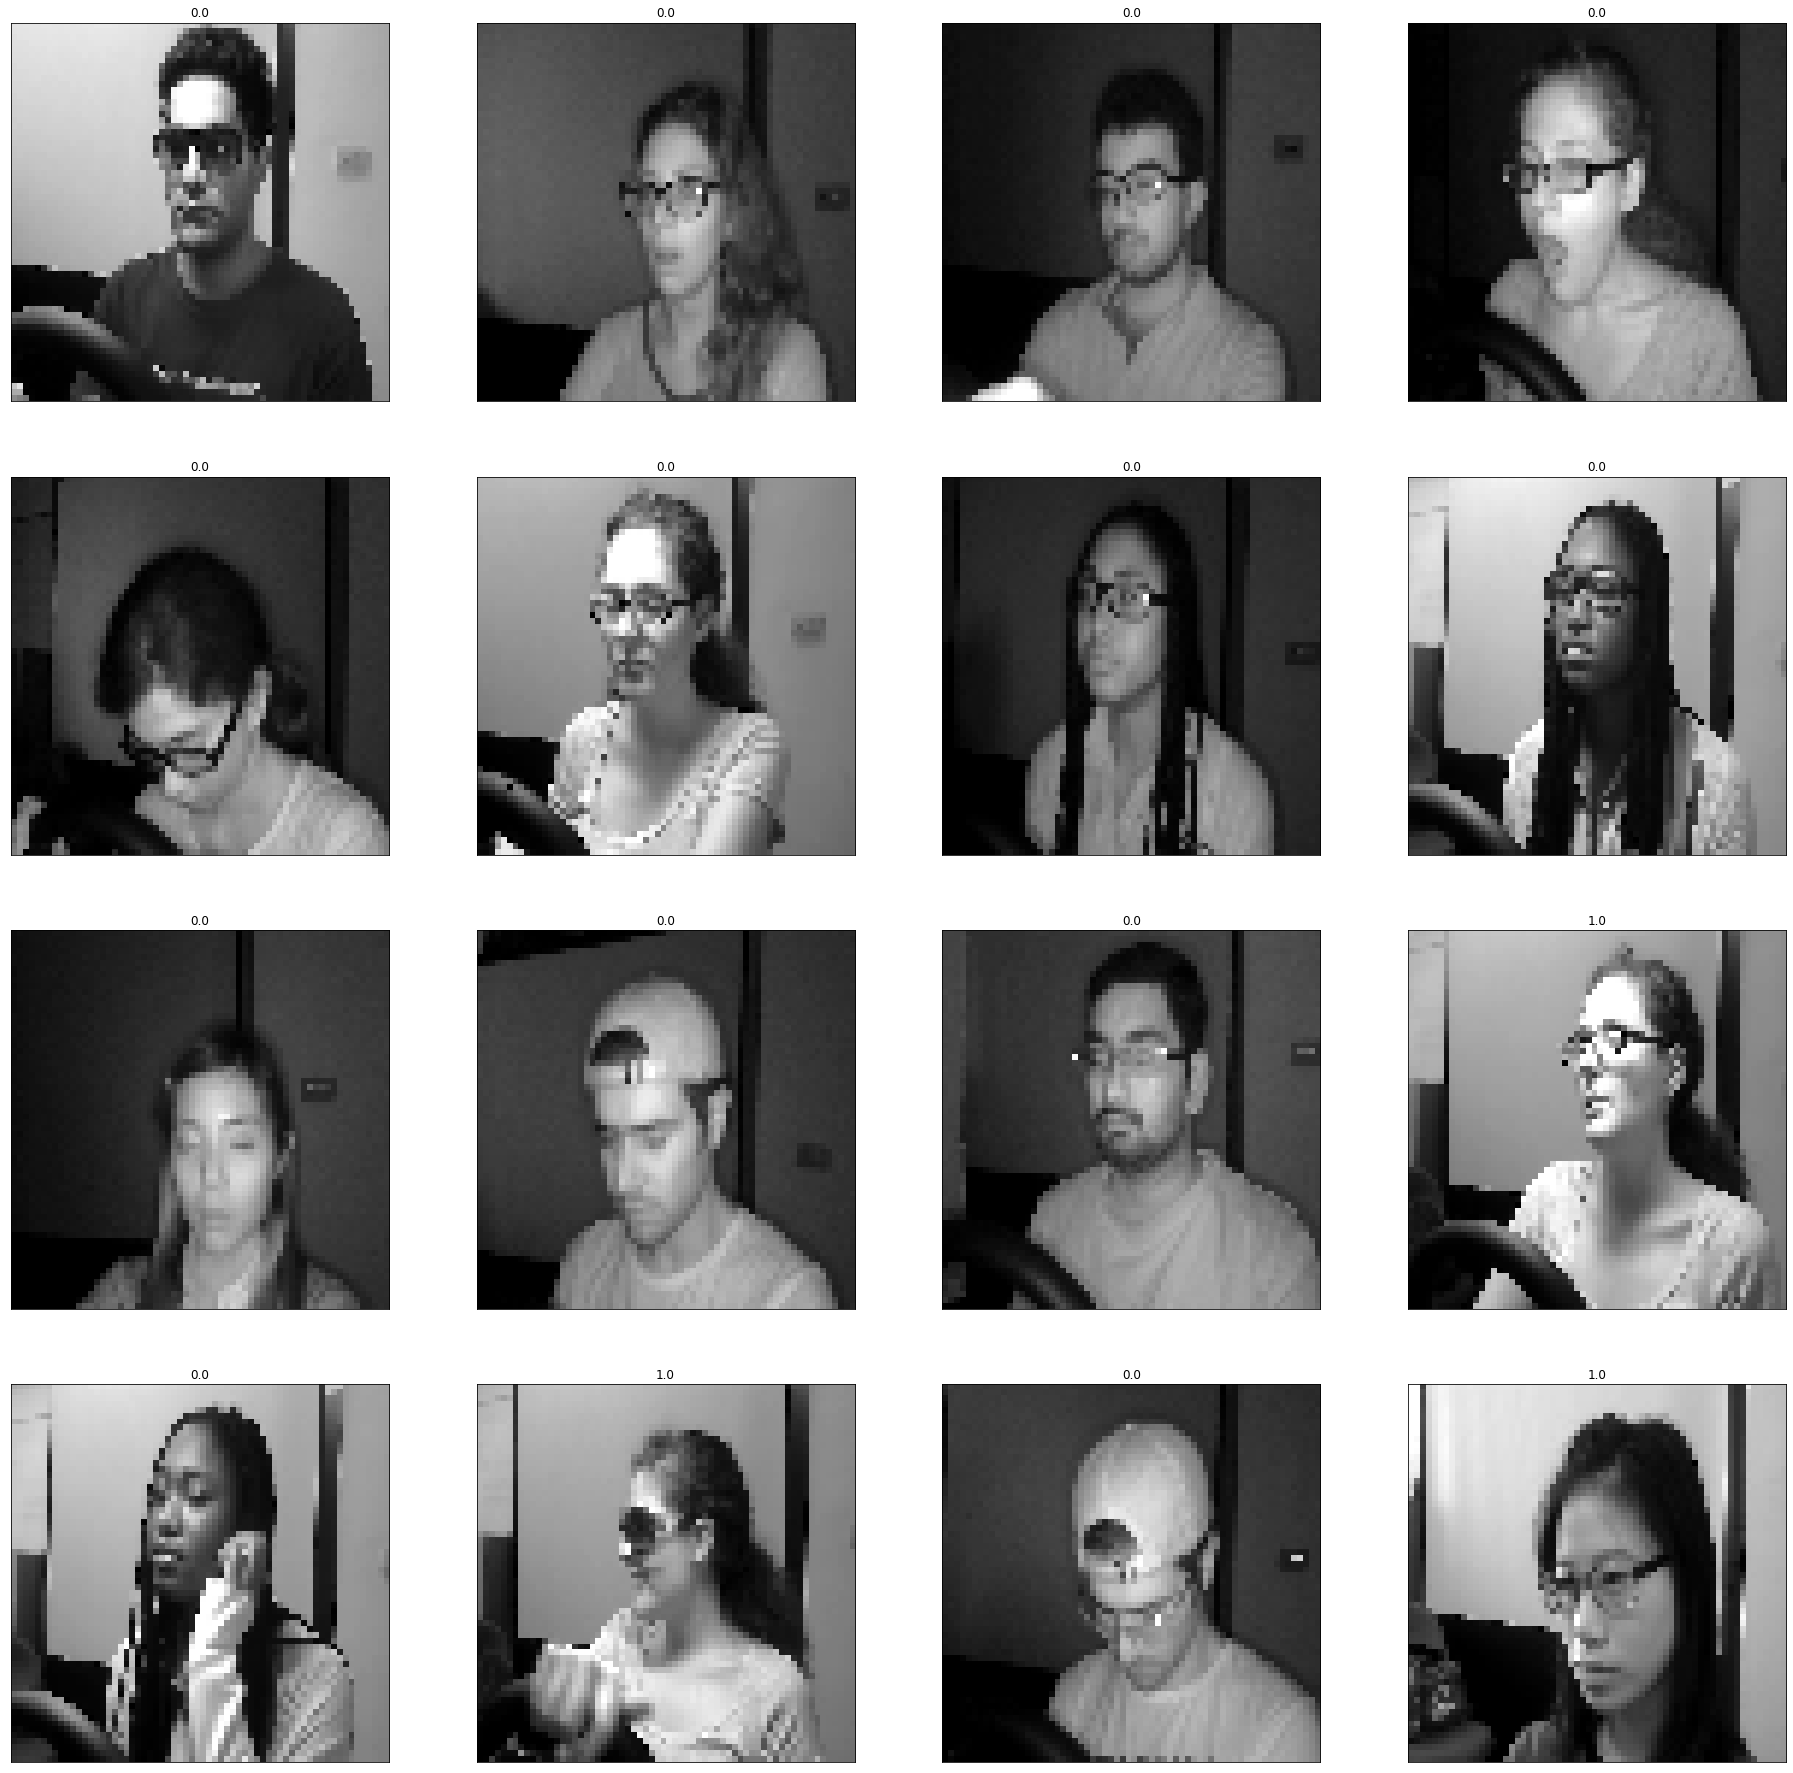

In [3]:
x,y = train_generator.next()
fig = plt.figure(figsize=(32,32))
for i in range(0,16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x[i]))
    ax.set_title("{}".format(y[i]))
plt.show()

#1 is non drowsy, 0 is drowsy

In [4]:
import keras
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Reshape, Permute, Multiply, Input, Activation
from keras.models import Sequential, Model
import tensorflow.keras.backend as K

def SqueezeExcite(x, ratio=16, name=''):
    nb_chan = K.int_shape(x)[-1]

    y = GlobalAveragePooling2D(name='SE_avg_{}'.format(name))(x)
    y = Dense(nb_chan // ratio, activation='relu', name='se_dense1_{}'.format(name))(y)
    y = Dense(nb_chan, activation='sigmoid', name='dense2_{}'.format(name))(y)

    y = Multiply(name='se_mul_{}'.format(name))([x, y])
    return y

def SE_Conv2D_block(x, filters, kernel_size, name):
    y = Conv2D(filters, kernel_size, padding='same', name='conv_{}'.format(name))(x)
    #squeeze excite in this
    y = SqueezeExcite(y, ratio=16, name=name)
    #other relu and maxpools
    y = BatchNormalization(name='BatchNorm_{}'.format(name))(y)
    y = Activation('relu', name='Activation_{}'.format(name))(y)
    y = MaxPool2D(pool_size=(2, 2), padding='same', name='{}_pool'.format(name))(y)
    y = Dropout(0.25)(y)
    return y


def SE_Dense_block(x, size, name, bn=True):
    y = Dense(size, name='dense_{}'.format(name))(x)
    if bn:
        y = BatchNormalization(name='BatchNorm_{}'.format(name))(y)
    y = Activation('relu', name='Activation_{}'.format(name))(y)
    return y

In [12]:
#huge thanks to -->https://github.com/arthurdouillard/keras-squeeze_and_excitation_network


def SE_Model(nb_class, input_shape=(64, 64, 3), include_top=True, weights = False):
    """SE net without the splitted stream."""

    img_input = Input(shape=input_shape)

    x = SE_Conv2D_block(img_input, 32, (3, 3), name='block1')
    

    params = [
        (64, (3, 3)),
        (128, (3, 3)),
        (256, (3, 3))
    ]

    for i, (filters, kernel_size) in enumerate(params, start=2):
        x = SE_Conv2D_block(x, filters, kernel_size, name='block{}'.format(i))

    if include_top:
        x = Flatten(name='flatten')(x)
#         x = SE_Dense_block(x, 512, 'top1', bn=True)
#         x = SE_Dense_block(x, 128, 'top2', bn=True)
#         x = SE_Dense_block(x, 32, 'top3', bn=True)
        x = Dense(nb_class, activation='sigmoid')(x)

    model = Model(inputs=img_input, outputs=x)

    if weights:
        print('Loading')
        model.load_weights(weights)
        print("Weight Loaded")

    return model

model = SE_Model(nb_class=1)
model.summary()
# model.compile()

optimizer = keras.optimizers.Adam(lr=0.00001)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()
val_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_block1 (Conv2D)            (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
SE_avg_block1 (GlobalAveragePoo (None, 32)           0           conv_block1[0][0]                
__________________________________________________________________________________________________
se_dense1_block1 (Dense)        (None, 2)            66          SE_avg_block1[0][0]              
____________________________________________________________________________________________

In [55]:


# model = Sequential(
# [
#     keras.Input((64,64,3)),
#     Conv2D(3, 3, activation='relu', padding = 'same'),
#     BatchNormalization(),
#     MaxPool2D((2,2)),
#     Dropout(0.5),
    
#     Conv2D(16, 3, activation='relu', padding = 'same'),
#     BatchNormalization(),
#     MaxPool2D((2,2)),
    
#     Conv2D(32, 3, activation='relu', padding = 'same'),
#     BatchNormalization(),
#     MaxPool2D((2,2)),
#     Dropout(0.5),
    
#     Conv2D(64, 3, activation='relu', padding = 'same'),
#     BatchNormalization(),
#     MaxPool2D((2,2)),
    
    
#     Flatten(),
#     Dense(1, activation='sigmoid'),
# ]
# )

# optimizer = keras.optimizers.Adam(learning_rate=0.01)
# loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
# acc_metric = keras.metrics.CategoricalAccuracy()
# val_acc_metric = keras.metrics.BinaryAccuracy()

# model.summary()


In [13]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)

        loss = loss_fn(y, y_pred)
        
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    acc_metric.update_state(y, y_pred)
    print("loss value is ",loss)
    
    return loss, y_pred

In [14]:
@tf.function
def test_step(x, y):
    val_preds = model(x, training=False)
    loss = val_loss_fn(y, val_preds)
    print("loss value in valid is ",loss)
    # Update val metrics
    val_acc_metric.update_state(y, val_preds)
    return val_preds, loss

In [15]:
import cv2


def put_text(imgs, actuals, preds):
    result = np.empty_like(imgs)
    for i in range(imgs.shape[0]):
        actual = actuals[i]
        pred = preds[i]
        if isinstance(actual, bytes):
            actual = actual.decode()
            
        if isinstance(pred, bytes):
            pred = pred.decode() 
        # You may need to adjust text size and position and size.
        # If your images are in [0, 255] range replace (0, 0, 1) with (0, 0, 255)
        
        result[i, :, :, :] = cv2.putText(imgs[i, :, :, :], str(actual), (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
        result[i, :, :, :] = cv2.putText(result[i, :, :, :], str(pred), (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
    return result


In [16]:
import io

def plot_fig(fpr,tpr,roc_auc):
    fig = plt.figure()
#     print(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Diagram')
    plt.legend(loc="lower right")
    #store
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image
    

In [ ]:
#todo: store tpr and fpr in arrays for each epoch and take their avg (sum/totalNo.)
#plot roc auc for that and store in tensorboard
from datetime import datetime

from sklearn.metrics import roc_curve, auc

num_epochs = 10

train_writer = tf.summary.create_file_writer('logs/SEModel/train', max_queue = 10)
valid_writer = tf.summary.create_file_writer('logs/SEModel/validation', max_queue = 10)

total_train_files = 0
total_valid_files = 0



for epoch in range(num_epochs):
    print(f"\nStart of Training Epoch {epoch}")
    print(train_generator.samples//16)
    #0 at the begining of every epoch
    fpr=[]
    tpr=[]
    
    valid_tpr=[]
    valid_fpr=[]
    for batch_idx in range(train_generator.samples//16):
        recent_batch = train_generator.next()
        x_batch = recent_batch[0]
        y_batch = recent_batch[1]
        
        loss_value, y_pred = train_step(x_batch, y_batch)
        #change (1,16) to (1,batch_number)
        y_preds = np.reshape(tf.get_static_value(y_pred),(1,16))[0]
#         print(y_batch, y_preds)
        
        if batch_idx % 50 == 0:
            print(f"epoch {epoch}, batch {batch_idx} loss = {loss_value}, accuracy = {acc_metric.result()}")
      
            train_acc = acc_metric.result()
            #for roc
            batch_fpr, batch_tpr, _ = roc_curve(y_batch, y_preds)

            for i in range(len(batch_fpr)):
                fpr.append(batch_fpr[i])
                tpr.append(batch_tpr[i])
            
            
            with train_writer.as_default():
                tf.summary.scalar("train_accuracy", train_acc,step = total_train_files)
                tf.summary.scalar("train_loss", loss_value, step = total_train_files)
                
#                 tf.summary.image('roc', roc_img, step=total_train_files)
                
                annotated_images = put_text(x_batch, y_batch, y_preds)
                tf.summary.image('train_images', annotated_images, max_outputs=12, step = total_train_files)
                
                tf.summary.histogram("predicted_output", y_preds, step=total_train_files)
                total_train_files += 50
        if batch_idx%100 == 0 and batch_idx!=0:
            break
                
                
                
                
    roc_auc = auc(np.sort(fpr), np.sort(tpr))
    image = plot_fig(np.sort(fpr), np.sort(tpr), roc_auc)
    with train_writer.as_default():
        tf.summary.image('roc_train', image, step=epoch)
        
    print(f"Accuracy over epoch {train_acc}")
    
    acc_metric.reset_states()
    
    #for validataion at the end of every epoch
    for val_batch_idx in range(validation_generator.samples//16):
        recent_validation_batch = validation_generator.next()
        x_validation_batch = recent_validation_batch[0]
        y_validation_batch = recent_validation_batch[1]
        
        val_y_preds,val_loss = test_step(x_validation_batch,y_validation_batch)
        val_y_pred = np.reshape(tf.get_static_value(val_y_preds),(1,16))[0]
        val_acc = val_acc_metric.result()
        
        if val_batch_idx % 50 == 0:
            print(f"Validation acc in valid batch {val_batch_idx}: %.4f" % (float(val_acc),))
            #for roc
            batch_fpr, batch_tpr,_ = roc_curve(y_validation_batch, val_y_pred)

            for i in range(len(batch_fpr)):
                valid_fpr.append(batch_fpr[i])
                valid_tpr.append(batch_tpr[i])
                
            with valid_writer.as_default():
                tf.summary.scalar("validation_accuracy", val_acc, step=total_valid_files)
                tf.summary.scalar("validation_loss", val_loss, step=total_valid_files)
            total_valid_files += 50
        if val_batch_idx%100 == 0 and val_batch_idx!=0:
            break
    roc_auc = auc(np.sort(fpr), np.sort(tpr))
    valid_roc_image = plot_fig(np.sort(valid_fpr), np.sort(valid_tpr), roc_auc)
    with train_writer.as_default():
        tf.summary.image('roc_valid', valid_roc_image, step=epoch)

    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc)))
    
    model.save_weights(f'{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")} epoch {epoch}.h5')
    
train_writer.close()
valid_writer.close()


Start of Training Epoch 0
35546
loss value is  Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
loss value is  Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
epoch 0, batch 0 loss = 0.828657865524292, accuracy = 0.375
epoch 0, batch 50 loss = 0.721709132194519, accuracy = 0.5036764740943909
epoch 0, batch 100 loss = 0.7370443940162659, accuracy = 0.531559407711029
Accuracy over epoch 0.531559407711029
loss value in valid is  Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Validation acc in valid batch 0: 0.6875
Validation acc in valid batch 50: 0.5772
Validation acc in valid batch 100: 0.5786
Validation acc: 0.5786

Start of Training Epoch 1
35546
epoch 1, batch 0 loss = 0.7013685703277588, accuracy = 0.8125
epoch 1, batch 50 loss = 0.6873123049736023, accuracy = 0.5686274766921997
epoch 1, batch 100 loss = 0.700377345085144, accuracy = 0.5810643434524536
Accuracy over epoch 0.5810643434524536
Valid

In [ ]:
# Compile the model
model.compile(optimizer='adam', 
              loss=['binary_crossentropy'], 
              metrics=['accuracy'])

In [ ]:
# Train the model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', 
                                       save_weights_only=True,
                                       monitor='val_accuracy'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', update_freq='batch', profile_batch = 0),
]

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

hist = model.fit(train_generator,
                 epochs=10,
                 batch_size=train_generator.samples,
                 validation_data=validation_generator,
                 validation_steps=validation_generator.samples,
                 workers=32,
                 verbose=1,
                 callbacks = my_callbacks) #, validation =yes

Epoch 1/10
35547/35547 [==============================] - 63776s 2s/step - loss: 0.6595 - accuracy: 0.6082 - val_loss: 0.7512 - val_accuracy: 0.4617
Epoch 2/10
35547/35547 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.6979

In [11]:
score = model.evaluate(test_generator,verbose=1)
print('Test accuracy:', score[1])

 171/1354 [==>...........................] - ETA: 3:15:28 - loss: 1.1569 - accuracy: 0.5637

KeyboardInterrupt: 

In [54]:
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.flip(frame,1)

    # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    to_test = cv2.resize(frame,(64,64))
#     print(to_test.shape)
    result = model.predict(to_test.reshape(1,64,64,3))
    
    # Display the resulting frame
    prediction = ''
    if result[0][0]>0.5:
        prediction = 'non-drowsy'
    else:
        prediction = 'drowsy'
        
    cv2.putText(frame, prediction, (10, 200), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 3) 
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [56]:
model_json = model.to_json()
with open("baseModel.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('1-inception_lstm.h5')
print('model saved success')

model saved success


AttributeError: 'dict' object has no attribute 'history'